Hrubá pipeline z článku Toroidal topology of population activity in
grid cells https://doi.org/10.1038/s41586-021-04268-7. Grid cells jsou buňky v entorhinální kůře myši, kódující prostorovou orientaci. Mapa jejich aktivací v prostoru vytváří "dláždicový" patern. V článku se ukazuje, že "joint activity of grid cells ... resides on a toroidal manifold". Tj. lze z projekce signálu grid cells na torus, lze zjistit, kde se myš nachází v prostoru.

Pipeline sketch: Load data time series -> cluster neurons -> bin -> smooth -> PCA -> UMAP -> decode + quantify

Not working, unknown proper parameter combinations
Do: Parameter search, ask for code.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA
import umap
from sklearn.cluster import KMeans
from ripser import Rips
import plotly.graph_objs as go
import matplotlib.cm as cm
import math
from scipy.ndimage import gaussian_filter1d

/home/martin/anaconda3/envs/caiman/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/martin/anaconda3/envs/caiman/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/martin/anaconda3/envs/caiman/lib/python3.10/site-packages/umap/d

In [71]:
signal_path = './DataR1/spikes_mod2.npy'
time_path = './DataR1/t.npy'
x_path = './DataR1/x.npy'
y_path = './DataR1/y.npy'
z_path = './DataR1/z.npy'

In [72]:
#load npy arrays
signal = np.load(signal_path, allow_pickle=True).item()
time = np.load(time_path)
x = np.load(x_path)
y = np.load(y_path) 
z = np.load(z_path)

for key, arr in signal.items():
    print(f"Length of array with key {key}: {len(arr)}")
print(x.shape, y.shape, z.shape)

Length of array with key 0: 11254
Length of array with key 1: 18523
Length of array with key 2: 12465
Length of array with key 3: 14215
Length of array with key 4: 25026
Length of array with key 5: 16502
Length of array with key 6: 25776
Length of array with key 7: 27973
Length of array with key 8: 10871
Length of array with key 9: 13144
Length of array with key 10: 14362
Length of array with key 11: 16326
Length of array with key 12: 10323
Length of array with key 13: 16570
Length of array with key 14: 12852
Length of array with key 15: 23721
Length of array with key 16: 17466
Length of array with key 17: 26053
Length of array with key 18: 18286
Length of array with key 19: 14821
Length of array with key 20: 17777
Length of array with key 21: 687
Length of array with key 22: 19395
Length of array with key 23: 41667
Length of array with key 24: 28744
Length of array with key 25: 26298
Length of array with key 26: 34511
Length of array with key 27: 52633
Length of array with key 28: 457

In [73]:
#Bin array [neurons,time] in time for each neuron using mean. 
def bin_array(array, bin_size):
    # Reshape 1D array to 2D array
    if array.ndim == 1:
        array = array.reshape(1, -1)  

    # Get the dimensions of the input array
    num_neurons, num_timepoints = array.shape

    # Calculate the number of bins based on the specified bin size
    num_bins = num_timepoints // bin_size

    # Initialize an array to store the binned values
    bin_array = np.zeros((num_neurons, num_bins))

    # Iterate over each time bin
    for bin_idx in range(num_bins):
        # Determine the start and end indices for the current bin
        start_idx = bin_idx * bin_size
        end_idx = min((bin_idx + 1) * bin_size, num_timepoints)

        # Calculate the mean value for each neuron within the current time bin
        bin_array[:, bin_idx] = np.mean(array[:, start_idx:end_idx], axis=1)

    # Remove singleton dimensions (squeeze) and return the binned array
    return np.squeeze(bin_array)

def plot_spike_heatmap(spike_array, cmap='viridis', xlabel='Time Bins', ylabel='Neurons', title='Spike Heatmap', colorbar_label='Spike Presence'):
    plt.imshow(spike_array, cmap=cmap, aspect='auto')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.colorbar(label=colorbar_label)
    plt.show()

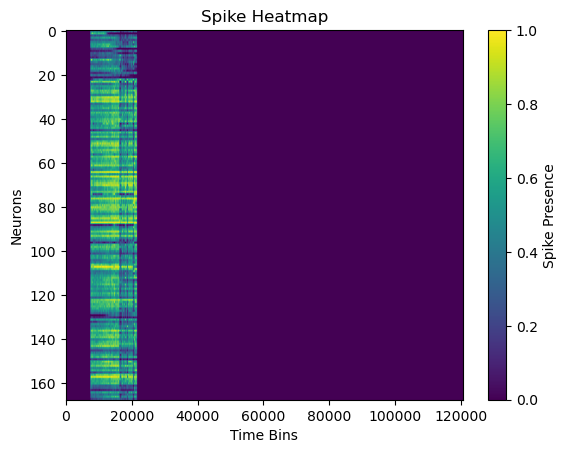

In [74]:
max_length = max(len(arr) for arr in signal.values())

spike_array = np.zeros((len(signal), max_length))

# Fill in the array with spike presence, floor() bins the signal array, could be fixed if Hz or signal_start/end known beforehand
for i, (key, arr) in enumerate(signal.items()):
    for j in arr:
        spike_array[i,math.floor(j) ] = 1

plot_spike_heatmap(spike_array)

In [75]:
#extract signal
last_nonzero_time = np.max(np.where(np.any(spike_array != 0, axis=0)))
first_nonzero_time = np.min(np.where(np.any(spike_array != 0, axis=0)))

spikes = spike_array[:,first_nonzero_time:last_nonzero_time]

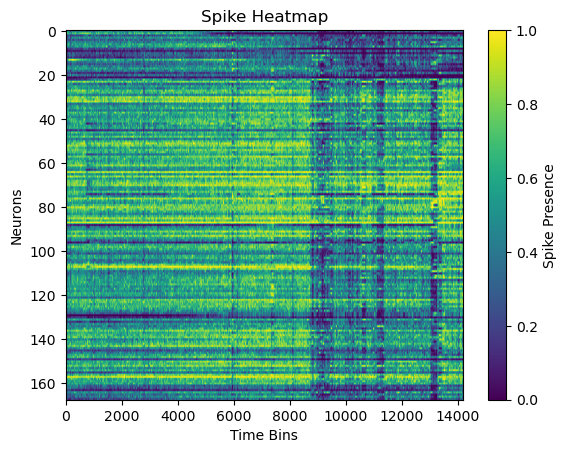

In [76]:
plot_spike_heatmap(spikes)

In [77]:
#position and signal were recorderded differently and have to be aligned
print(spikes.shape, x.shape, y.shape)

x = x[0:spikes.shape[1]*100]
y = y[0:spikes.shape[1]*100]
aligned_x = bin_array(x,100)
aligned_y = bin_array(y,100)

print(aligned_x.shape, aligned_y.shape)

(168, 14182) (1418299,) (1418299,)
(14182,) (14182,)


In [94]:
#in the paper, 3 different types of neurons were identified by clustering neuron autocorrelograms
#skipped

clustered_spikes = []

# autocorrelograms = []
# for neuron_data in spikes:
#     autocorr = np.correlate(neuron_data, neuron_data, mode='full')
#     autocorrelograms.append(autocorr[len(neuron_data)-1:])

# autocorrelograms_array = np.array(autocorrelograms)

# num_clusters = 2

# kmeans = KMeans(n_clusters=num_clusters, random_state=42)
# clusters = kmeans.fit_predict(autocorrelograms_array)

# clustered_spikes = [spikes[clusters == i] for i in range(num_clusters)]

In [95]:
#in the paper, binned by 10 ms, but Hz not known so binned as convenient 
#Skipped binning by position/time

clustered_spikes.insert(0, spikes)
neuron_arrays = np.array(clustered_spikes) 
smoothed_arrays = []

bin_size = 5

for neuron_array in neuron_arrays:
    binned_array = bin_array(neuron_array,bin_size)
    smoothed_array = np.array([gaussian_filter1d(signal, sigma=1, axis=-1) for signal in binned_array])
    smoothed_arrays.append(smoothed_array)
    
binned_x = bin_array(aligned_x,bin_size)
binned_y = bin_array(aligned_y,bin_size)


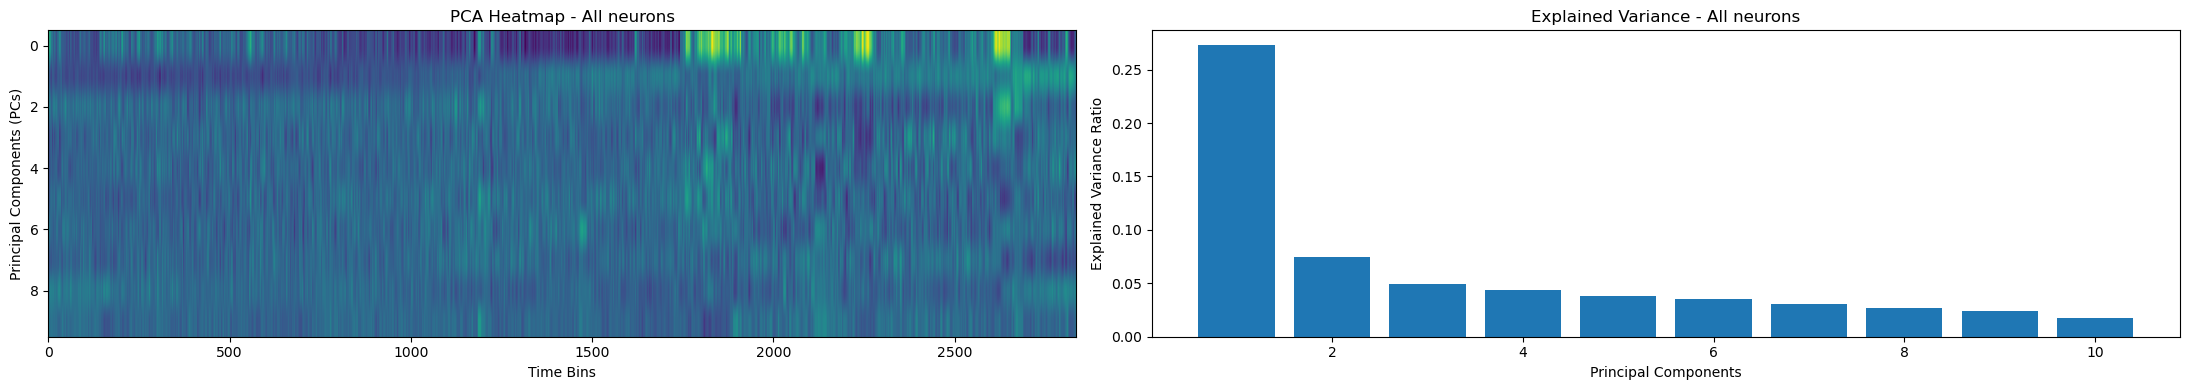

In [96]:
pca_signals = []

fig, axes = plt.subplots(nrows=1, ncols=len(neuron_arrays)*2, figsize=(22, 4))
# Perform PCA and create plots for each set of smoothed signals
for i, (smoothed_signals, title_suffix) in enumerate(zip(smoothed_arrays,
                                                          ['All neurons', 'Cluster 1', 'Cluster 2', 'Cluster3'])):
    # Apply PCA to remove noise/find relevant PCs
    pca = PCA(n_components=10)
    pca_signal = pca.fit_transform(smoothed_signals.T).T
    pca_signals.append(pca_signal[:6])
    explained_variance_ratio = pca.explained_variance_ratio_

    # PCA Heatmap
    axes[i * 2].imshow(pca_signal, cmap='viridis', aspect='auto')
    axes[i * 2].set_title(f'PCA Heatmap - {title_suffix}')
    axes[i * 2].set_xlabel('Time Bins')
    axes[i * 2].set_ylabel('Principal Components (PCs)')

    # Explained variance ratio bar plot
    axes[i * 2 + 1].bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
    axes[i * 2 + 1].set_title(f'Explained Variance - {title_suffix}')
    axes[i * 2 + 1].set_xlabel('Principal Components')
    axes[i * 2 + 1].set_ylabel('Explained Variance Ratio')

plt.tight_layout()
plt.show()


In [97]:
#find rotation matrix of vector a to b
def rotation_matrix_from_vectors(a, b):
    # Calculate the cross product of vectors a and b
    v = np.cross(a, b)

    # Calculate the dot product of vectors a and b
    c = np.dot(a, b)

    # Calculate the magnitude of the cross product vector
    s = np.linalg.norm(v)

    # Create the skew-symmetric cross product matrix (K matrix)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])

    # Calculate the rotation matrix using Rodrigues' rotation formula
    rotation_matrix = np.eye(3) + kmat + np.dot(kmat, kmat) * ((1 - c) / (s ** 2))

    return rotation_matrix

#used to center a circular pointcloud
def align_point_cloud(point_cloud):
    # Calculate the center of the point cloud
    center = np.mean(point_cloud, axis=0)

    # Center the point cloud by subtracting the mean
    centered_point_cloud = point_cloud - center

    # Perform Principal Component Analysis (PCA) to get the normal vector
    pca = PCA(n_components=3)
    pca.fit(centered_point_cloud)
    normal = pca.components_[2]

    # Define the desired z-axis
    z_axis = np.array([0, 0, 1])

    # Calculate the rotation matrix to align the normal vector with the z-axis
    rotation_matrix = rotation_matrix_from_vectors(normal, z_axis)

    # Apply the rotation matrix to align the point cloud
    aligned_point_cloud = np.dot(centered_point_cloud, rotation_matrix.T)

    return aligned_point_cloud


In [98]:
#apply umap, a non-linear dimensionality reduction technique to find a manifold underlying grid cell activity
#activity of a module of grid cells was found to be underlied by a toroidal-shaped manifold
embeddings = []
for signal in pca_signals:
    reducer = umap.UMAP(n_components=3, metric='cosine', n_neighbors=20, min_dist=1)
    embedding = reducer.fit_transform(signal.T)
    aligned_embedding = align_point_cloud(embedding)
    embeddings.append(aligned_embedding)

In [102]:
#Mouse is moving on a 2d XxY plane. Bin the 2d XxY plane into several tiles and label them with different numbers
#Each grid cell fires at a specific location on the plane. Tiles should somewhat approximate the grid cells and map
# each grid cell to a different color.
#after projecting data on lower dimensions, grid cells/tiles/colors should be somewhat clustered together
def index_domain_by_values(data, N, multiplier=1):
    hist, bin_edges = np.histogram(data, bins=N)
    indices = np.ones(data.shape[0])*multiplier
    
    for i in range(N):
        bin_indexes = np.where((data >= bin_edges[i]) & (data <= bin_edges[i + 1]))[0]
        indices[bin_indexes] += i
    
    return indices

N = 9

indices1 = index_domain_by_values(binned_x,N)
indices2 = index_domain_by_values(binned_y, N, multiplier=N+1)

#each position now has different nubmer
positions = indices1*indices2

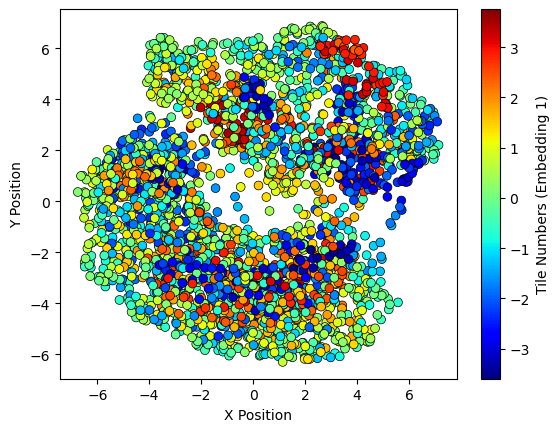

In [103]:
def scatterplot_with_color(data, x_label='X Position', y_label='Y Position', color_label='tile numbers', size=40, edgecolors='k', linewidths=0.5, cmap='jet'):
    plt.scatter(data[:, 0], data[:, 1], c=data[:, 2], cmap=cmap, s=size, edgecolors=edgecolors, linewidths=linewidths)
    plt.colorbar(label=color_label)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()
    
for i, embedding in enumerate(embeddings):
    combined_data = np.column_stack((embedding, positions))
    scatterplot_with_color(combined_data, color_label=f'Tile Numbers (Embedding {i + 1})')


In [106]:
def create_embedding_plot(embedding_data):

    trace_embedding = go.Scatter3d(
        x=embedding_data[:, 0],
        y=embedding_data[:, 1],
        z=embedding_data[:, 2],
        mode='markers',
        marker=dict(size=2, colorscale='jet', color=positions),
    )

    layout_embedding = go.Layout(
        scene=dict(
            xaxis=dict(title='Dimension 1'),
            yaxis=dict(title='Dimension 2'),
#             zaxis=dict(title='Dimension 3')
        )
    )

    return go.Figure(data=[trace_embedding], layout=layout_embedding)


In [107]:
plot = create_embedding_plot(embeddings[0])
plot.show()

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


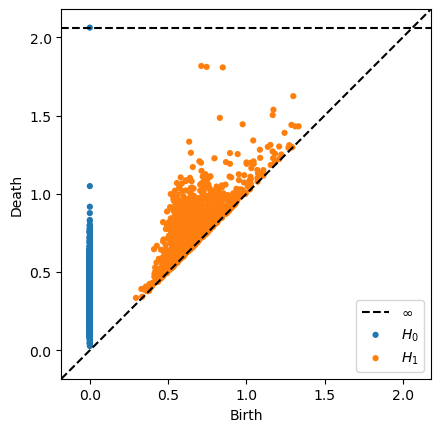

In [93]:
#some quantification ...
#for example, ripser uses persistent cohomology to quantify the topology of a point cloud by calculating Betti numbers
rips = Rips()
diagrams = rips.fit_transform(embeddings[0])
rips.plot(diagrams)

In [44]:
#decoding skipped